<a href="https://colab.research.google.com/github/NanaAkwasiAbayieBoateng/NLP/blob/main/Sentiment_Analysis_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
#!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing

In [159]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from  nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import itertools
import collections
from xgboost import XGBClassifier
import xgboost as xgb
%matplotlib inline
%autosave 5

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Autosaving every 5 seconds


In [160]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
tqdm.pandas(desc="Completed") # add progressbar to pandas, use progress_apply instead apply
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import interact #interactive plots
from IPython.display import clear_output

In [247]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
!unzip /content/drive/MyDrive/Data/Fake_True_News.zip
True_data = pd.read_csv('True.csv')
True_data['label']= 1
Fake_data = pd.read_csv('Fake.csv')
Fake_data['label']=0
True_data.head()

Archive:  /content/drive/MyDrive/Data/Fake_True_News.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: True.csv                


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [248]:
df = pd.concat([True_data,Fake_data],axis=0)
print(df.shape)
print(type(df.label))
df.info()

(44898, 5)
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [249]:
#df= df.sample(frac=0.1)
df.shape

(44898, 5)

In [250]:
# Create and register a new `tqdm` instance with `pandas`
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
#df["title"] = df["title"].progress_apply(preprocess)
#df["text"] = df["text"].progress_apply(preprocess)

In [251]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,title,text,subject,date,label
21322,Thousands rally for gay marriage in Australia ...,SYDNEY (Reuters) - Thousands of people rallied...,worldnews,"August 26, 2017",1
15348,“BLOOD ON THEIR HANDS” FOR VOTING RIGHTS: The ...,It s time to stop hitting the snooze button Am...,politics,"Aug 9, 2015",0
21115,North Korean nuclear test prompts global conde...,LONDON (Reuters) - North Korea s biggest nucle...,worldnews,"September 3, 2017",1
5976,Mark Kirk Becomes First Republican To Un-Endo...,Facing a tough reelection against Congresswoma...,News,"June 7, 2016",0
15323,OBAMA’S OPEN BORDERS: ILLEGAL ALIEN DEPORTED 1...,He was just looking to the jobs most Americans...,politics,"Aug 15, 2015",0


The gensim.utils.simple_process utility can be used to accomplish some of the basic common text preprocessing and cleaning  such as tokenization and removing stop words.

In [252]:
stop_words = stopwords.words('english')
stop_words.extend(['said','say','from', 'subject', 're', 'edu', 'use'])
lemmatizer = WordNetLemmatizer() 
stemmer = SnowballStemmer("english")


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
           #token = [stemmer.stem(token)  for token in text.split() ]
           result.append(lemmatizer.lemmatize(token))
    return result

In [253]:
#@title Default title text
df["title"] = df["title"].apply(preprocess)
df["text"] = df["text"].apply(preprocess)

Combine title and text columns, this will later be used to demonstrate if classification performance improves  with this combination over using either title or text column alone to predict whether the news is Fake or Real.

In [254]:
df["title_text"] = df["text"]+df["title"]

In [255]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Looking at the subjects we can combine related subjects such  politicsNews and politics to politicsNews.

In [256]:
df.subject.replace({'politics':'politicsNews'},inplace=True)

In [257]:
#df['label'] = df['label'].astype(str)
df["label"].replace({0:"Fake",  1:"Real"},inplace=True)
df["label"].value_counts()

Fake    23481
Real    21417
Name: label, dtype: int64

#### What is the distribution of Subjects between the True and Fake News?

In [258]:
temp=df.groupby('label').apply(lambda x:x['title'].count()).reset_index(name='Counts')
#temp.label.replace({0:'False',1:'True'},inplace=True)
temp.style.background_gradient(cmap='Purples')

,label,Counts
0,Fake,23481
1,Real,21417


In [259]:
#Let's draw a Funnel-Chart for better visualization
fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.Counts,
    title = {"position": "top center", "text": "Funnel-Chart of News Distribution"}
    ))
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file1.html")

In [261]:
temp=df.groupby('label').apply(lambda x:x['title'].count()).reset_index(name='Counts')
#sub_tf_df.label.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(temp, x="label", y="Counts",
             color='Counts', barmode='group',
             title =  "Frequency of Real and Fake News Distribution",
             height=400)

fig.update_layout(
    font_family="Courier New",
    font_color="white",
    title_font_family="Times New Roman",
    title_font_color="white"
   # legend_title_font_color="green"
)
fig.update_xaxes(title_font_family="Arial")
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout( template="plotly_dark")
#fig =px.scatter(x=range(10), y=range(10))
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file2.html")

#### Common Words in News  Fake News Title

In [262]:
top = Counter([item for sublist in df[df.label == "Fake"]["title"] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Greens')

,Common_words,count
0,trump,9350
1,video,8558
2,obama,2582
3,hillary,2322
4,watch,1941
5,clinton,1175
6,president,1165
7,black,975
8,tweet,936
9,white,905


In [263]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Fake News Titles', orientation='h', 
             width=700, height=700,color='Common_words')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout( template="plotly_white")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file3.html")

#### Common Words in News Real News Title

In [179]:
top = Counter([item for sublist in df[df.label == "Real"]["title"] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')


,Common_words,count
0,trump,5567
1,say,2981
2,house,1452
3,russia,977
4,republican,976
5,north,926
6,korea,898
7,new,875
8,state,825
9,white,818


In [180]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Real news Titles', orientation='h', 
             width=700, height=700,color='Common_words')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout( template="plotly_dark")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file4.html")

#### Which Subjects have received the most News Coverage?

In [181]:
temp=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(temp,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file2.html")
fig.update_layout( template="plotly_dark")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file5.html")

#### Exploring Co-occurring Words (Bigrams)
Let's now explore certain words which occuur together in the tweets. Such words are called bigrams.A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words


In [182]:
from nltk import bigrams,trigrams,ngrams
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in df[df.label == "Real"]["text"]]

# Flatten list of bigrams in clean tweets
bigrams_all = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams_all)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])
bigram_df.style.background_gradient(cmap='Purples')

,bigram,count
0,"('united', 'state')",12215
1,"('donald', 'trump')",10169
2,"('white', 'house')",8419
3,"('washington', 'reuters')",6674
4,"('president', 'donald')",5930
5,"('north', 'korea')",5659
6,"('new', 'york')",4740
7,"('prime', 'minister')",4206
8,"('told', 'reuters')",3496
9,"('islamic', 'state')",3477


In [183]:
#df = title_per.to_frame().round(1)
fig.update_layout(
    title_text="High Frequency Bigrams  in Real News",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='High Frequency ', x=0.5, y=0.5, font_size=14, showarrow=False)])
fig = px.pie(bigram_df, values=bigram_df['count'].values, names= bigram_df.bigram, color_discrete_sequence=px.colors.sequential.YlGnBu,
             title='High Frquency Bigrams for Real News')
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(
   # autosize=False,
    width=800,
    height=800,
   
)
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file6.html")

#### Bigrams  of Fake News Headlines

In [184]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in df[df.label == "Fake"]["text"]]

# Flatten list of bigrams in clean tweets
bigrams_all = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams_all)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])
bigram_df.style.background_gradient(cmap='Purples')

,bigram,count
0,"('donald', 'trump')",16402
1,"('featured', 'image')",8069
2,"('hillary', 'clinton')",7312
3,"('white', 'house')",6749
4,"('united', 'state')",6674
5,"('twitter', 'com')",6567
6,"('pic', 'twitter')",6232
7,"('new', 'york')",4361
8,"('president', 'obama')",4104
9,"('president', 'trump')",4065


In [185]:
colors = ['mediumturquoise','gold' ]
colors1 = ['#F4D03F','#82E0AA', "#F1948A",]


# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels= bigram_df.bigram, values=bigram_df['count'], hole=.4)])

fig.update_traces(hoverinfo='label+value', textinfo='percent', textfont_size=15,
                  marker=dict(colors=px.colors.sequential.YlGnBu, line=dict(color='#000000', width=1)))

fig.update_layout(
   # autosize=False,
    width=800,
    height=800,
   
)
fig.update_layout(
    title_text="High Frequency Bigrams in Fake News ",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text=' ', x=0.5, y=0.5, font_size=14, showarrow=False)])
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file7.html")

#### Trigrams of Fake News


In [186]:
#list(ngrams(df.text.values[0],n=4))
# Create list of lists containing bigrams in tweets
#trigram = [list(bigrams(tweet)) for tweet in df[df.label == "Fake"]["text"]]
trigram = [list(ngrams(text,n=3)) for text in df[df.label == "Fake"]["text"]]

# Flatten list of bigrams in clean tweets
trigram_all = list(itertools.chain(*trigram))

# Create counter of words in clean bigrams
trigram_counts = collections.Counter(trigram_all)
trigram_df = pd.DataFrame(trigram_counts.most_common(20),
                             columns=['trigram', 'count'])
trigram_df.style.background_gradient(cmap='Blues')

,trigram,count
0,"('pic', 'twitter', 'com')",6185
1,"('donald', 'trump', 'realdonaldtrump')",1692
2,"('new', 'york', 'time')",1581
3,"('black', 'life', 'matter')",1319
4,"('president', 'donald', 'trump')",1049
5,"('president', 'united', 'state')",1015
6,"('president', 'barack', 'obama')",953
7,"('news', 'century', 'wire')",939
8,"('featured', 'image', 'video')",887
9,"('century', 'wire', 'say')",733


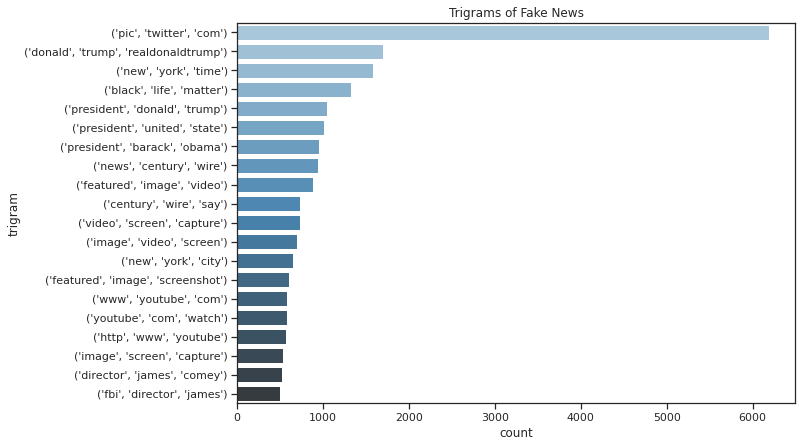

In [187]:
#fig = px.bar(trigram_df, x="count", y="trigram", title='Trigrams in Fake News', orientation='h', 
#             width=700, height=700)
#fig.show()
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 7)
ax = sns.barplot(x="count", y="trigram", data=trigram_df,
                 palette="Blues_d")
plt.title('Trigrams of Fake News')
plt.show()

#### Trigrams of Real News

In [188]:
trigram = [list(ngrams(text,n=3)) for text in df[df.label == "Real"]["text"]]

# Flatten list of bigrams in clean tweets
trigram_all = list(itertools.chain(*trigram))

# Create counter of words in clean bigrams
trigram_counts = collections.Counter(trigram_all)
trigram_df = pd.DataFrame(trigram_counts.most_common(20),
                             columns=['trigram', 'count'])
trigram_df.style.background_gradient(cmap='Blues')

,trigram,count
0,"('president', 'donald', 'trump')",5869
1,"('president', 'barack', 'obama')",2960
2,"('reuters', 'president', 'donald')",1562
3,"('washington', 'reuters', 'president')",1533
4,"('new', 'york', 'reuters')",845
5,"('elect', 'donald', 'trump')",834
6,"('president', 'elect', 'donald')",832
7,"('respond', 'request', 'comment')",806
8,"('president', 'vladimir', 'putin')",791
9,"('state', 'rex', 'tillerson')",673


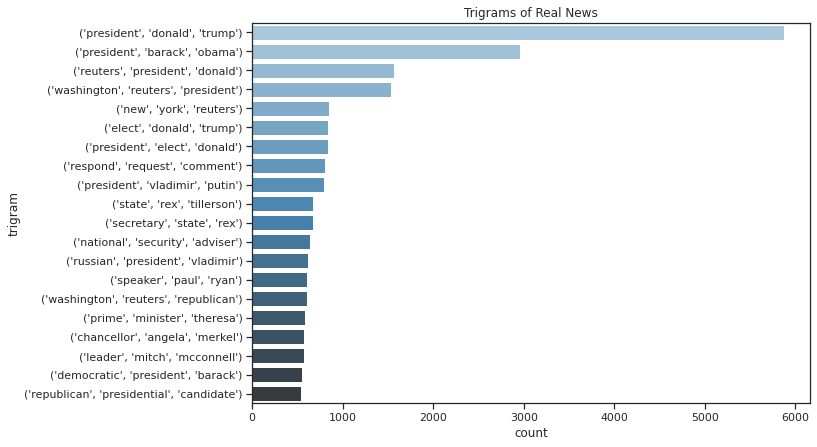

In [189]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 7)
ax = sns.barplot(x="count", y="trigram", data=trigram_df,
                 palette="Blues_d")
plt.title('Trigrams of Real News')
plt.show()

#### Word Cloud using the Real News

In [190]:
top = Counter([item for sublist in df[df.label == "Real"]["text"] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,trump,54734
1,state,37678
2,reuters,28976
3,president,28728
4,republican,23007
5,year,22622
6,government,19992
7,house,17030
8,new,16917
9,united,15590


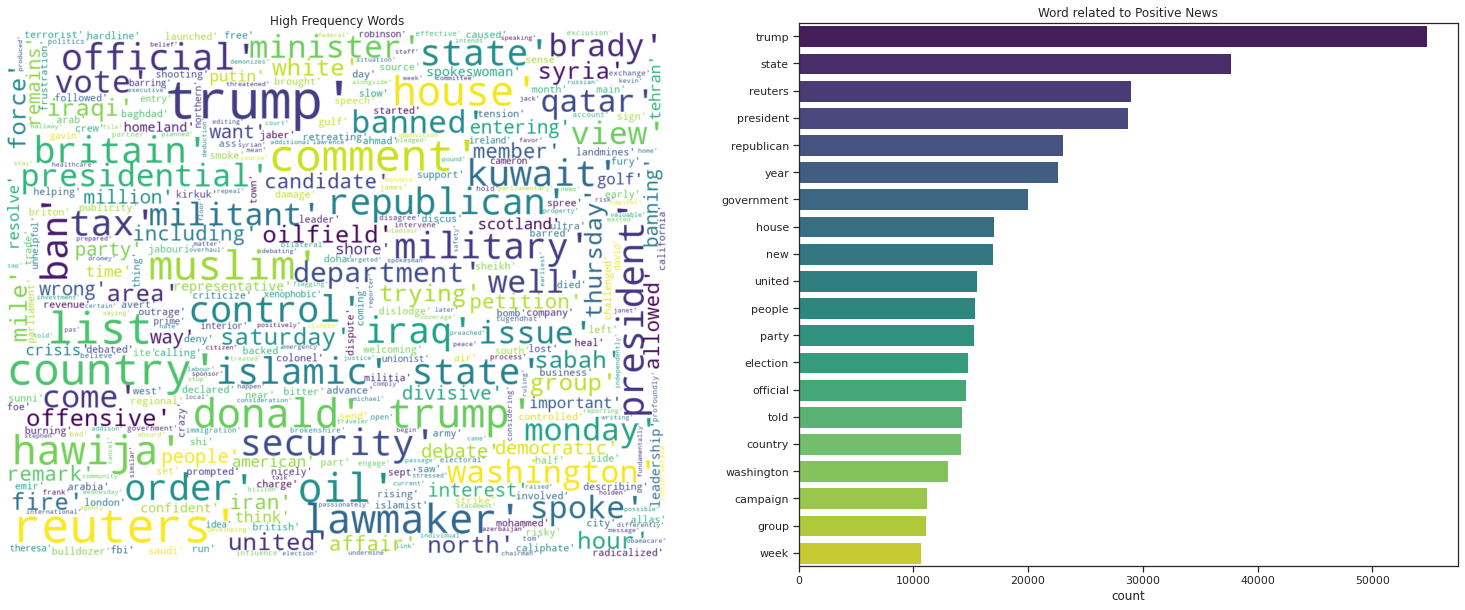

In [191]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline


from subprocess import check_output
from os import path
from wordcloud import WordCloud

#d = path.dirname("/Users/nanaakwasiabayieboateng/PythonNLTK")




# Read the whole text.
#text = str(train['text'])

#stopwords = set(STOPWORDS)
#stopwords.add("Chrysler")

color = ['black','white'];

#background_color="white", max_words=2000, mask=text,
#               stopwords=stopwords, contour_width=3, contour_color='steelblue'
    
fig, (ax1, ax2,) = plt.subplots(1, 2, figsize=[26, 10])
sns.set_color_codes("pastel")   


wordcloud = WordCloud(max_words = 2000,  
                       width=1000,
                       height=800,
                       colormap='viridis',
                      max_font_size=80, min_font_size=2,  # Font size range
                      background_color=color[1],
                    margin=0,
                     
               stopwords = stop_words).generate("".join(str(df[df.label == "Real"].text.values)))
ax1.imshow(wordcloud, interpolation = 'bilinear')

sns.color_palette("viridis", as_cmap=True)
ax2= sns.barplot(y="Common_words", x="count", data=temp,
            label="Total",palette="viridis")
ax2.set_ylabel('')  
ax2.set_title('Word related to Positive News');
#ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title('High Frequency Words');


#### Word Cloud using the Real  News

#### Lets Look at the Count of Words Distribution in the Title

In [192]:
top = Counter([item for sublist in df[df.label == "Fake"]["text"] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Greens')

,Common_words,count
0,trump,80049
1,president,28406
2,people,26678
3,state,23663
4,clinton,19866
5,time,19199
6,year,19074
7,obama,18838
8,like,18667
9,american,18106


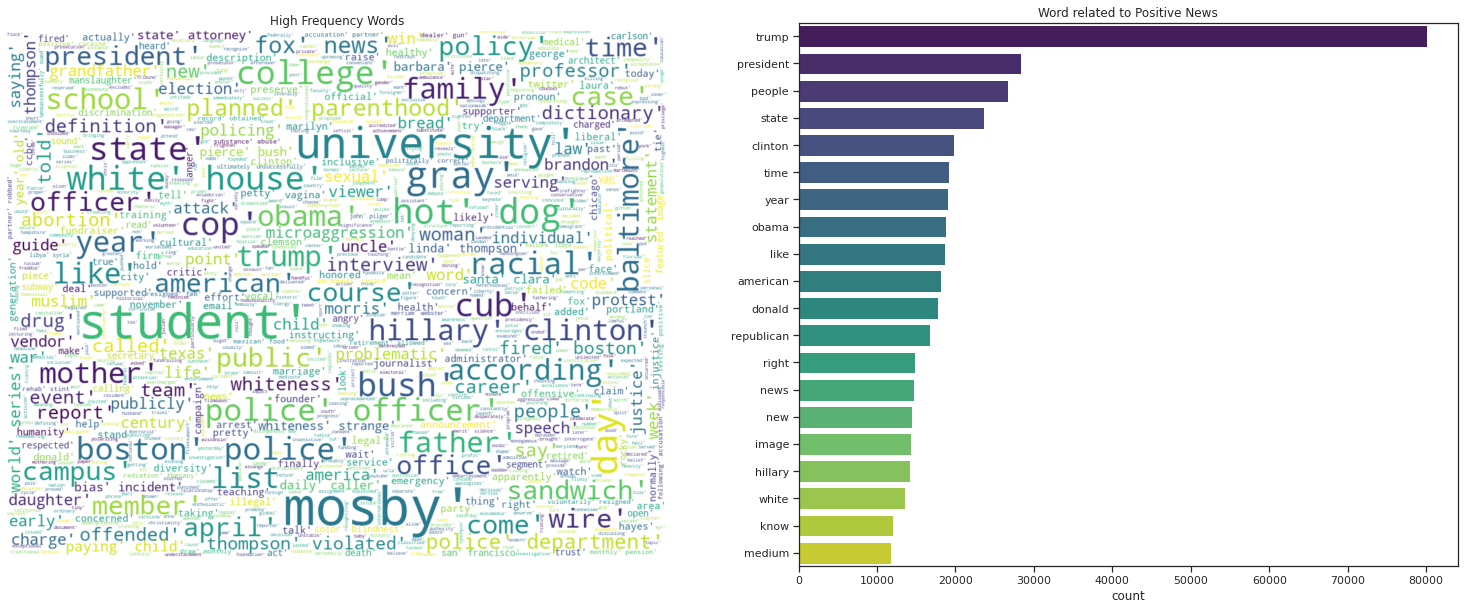

In [193]:
fig, (ax1, ax2,) = plt.subplots(1, 2, figsize=[26, 10])
sns.set_color_codes("pastel")   
color = ['black','white'];

wordcloud = WordCloud(max_words = 2000,  
                       width=1000,
                       height=800,
                       colormap='viridis',
                      max_font_size=80, min_font_size=2,  # Font size range
                      background_color=color[1],
                    margin=0,
                     
               stopwords = stop_words).generate("".join(str(df[df.label == "Fake"].text.values)))
ax1.imshow(wordcloud, interpolation = 'bilinear')

sns.color_palette("viridis", as_cmap=True)
ax2= sns.barplot(y="Common_words", x="count", data=temp,
            label="Total",palette="viridis")
ax2.set_ylabel('')  
ax2.set_title('Word related to Positive News');
#ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title('High Frequency Words');


  Donald Trunmp dominates the news whether fake or real.

#### Analysis Over Time

In [194]:
import datetime
from IPython.display import display, HTML

df["date"] = pd.to_datetime(df["date"], errors='coerce')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
h= df.head(2)

# render dataframe as html
html = h.to_html(render_links=True, index=False).replace('<th>','<th style = "background-color: #48c980">')
# write html to file 
text_file = open("/content/drive/MyDrive/Colab Notebooks/NLP/h.html", "w") 
text_file.write(html) 
text_file.close() 
HTML('h.html')



title,text,subject,date,label,title_text,year,month,day
"[telefonica, suspends, customer, service, operation, guatemala, killing]","[guatemala, city, reuters, guatemalan, unit, firm, telefonica, suspended, customer, service, operation, closed, shop, weekend, employee, shot, death, central, american, nation, killing, wounding, fourth, employee, occurred, separate, attack, friday, typical, case, extortion, business, area, dangerous, part, country, company, representative, asked, named, safety, concern, told, reuters, sunday, safety, employee, decided, suspend, customer, service, restart, tomorrow, monday, gradually, recover, normal, operation, representative, local, medium, published, transcript, supposed, conversation, employee, movistar, telefonica, local, unit, man, attempting, extort, police, spokesman, pablo, castillo, authority, investigating, killing, guatemala, struggling, endemic, gang, violence, especially, powerful, mara, salvatrucha, known, rival, calle, movistar, million, client, guatemala]",worldnews,2017-11-13,Real,"[guatemala, city, reuters, guatemalan, unit, firm, telefonica, suspended, customer, service, operation, closed, shop, weekend, employee, shot, death, central, american, nation, killing, wounding, fourth, employee, occurred, separate, attack, friday, typical, case, extortion, business, area, dangerous, part, country, company, representative, asked, named, safety, concern, told, reuters, sunday, safety, employee, decided, suspend, customer, service, restart, tomorrow, monday, gradually, recover, normal, operation, representative, local, medium, published, transcript, supposed, conversation, employee, movistar, telefonica, local, unit, man, attempting, extort, police, spokesman, pablo, castillo, authority, investigating, killing, guatemala, struggling, endemic, gang, violence, especially, powerful, mara, salvatrucha, known, rival, calle, movistar, million, client, guatemala, telefonica, suspends, customer, service, ...]",2017.0,11.0,13.0
"[bush, speechwriter, level, trump, devastating, inauguration, day, tweet]","[donald, trump, officially, depressingly, take, white, house, today, george, bush, speechwriter, david, frum, strong, word, inauguration, day, course, trump, bother, actually, going, job, monday, decided, day, vacation, plenty, time, read, tweet, frum, posted, twitter, throw, temper, tantrum, frum, called, trump, worst, human, president, includes, president, owned, slave, worst, human, enter, presidency, include, slaveholder, david, frum, davidfrum, january, doubt, slavery, existed, donald, trump, definitely, slaveholder, hell, company, product, cheap, labor, overseas, slave, manufacture, product, free, know, trump, love, fact, percent, trump, supporter, actually, believe, freeing, slave, bad, idea, let, forget, white, supremacist, flocked, support, trump, campaign, trump, adviser, frum, followed, tweet, ...]",News,2017-01-20,Fake,"[donald, trump, officially, depressingly, take, white, house, today, george, bush, speechwriter, david, frum, strong, word, inauguration, day, course, trump, bother, actually, going, job, monday, decided, day, vacation, plenty, time, read, tweet, frum, posted, twitter, throw, temper, tantrum, frum, called, trump, worst, human, president, includes, president, owned, slave, worst, human, enter, presidency, include, slaveholder, david, frum, davidfrum, january, doubt, slavery, existed, donald, trump, definitely, slaveholder, hell, company, product, cheap, labor, overseas, slave, manufacture, product, free, know, trump, love, fact, percent, trump, supporter, actually, believe, freeing, slave, bad, idea, let, forget, white, supremacist, flocked, support, trump, campaign, trump, adviser, frum, followed, tweet, ...]",2017.0,1.0,20.0


In [195]:
import seaborn as sns
temp=df.groupby('year').apply(lambda x:x['text'].count()).reset_index(name='Counts')
temp.style.set_properties(**{'background-color': 'pink',
                            'color': 'black',
                            'border-color': 'white'})

temp.style.background_gradient(cmap='Greens')

,year,Counts
0,2015.000000,2479
1,2016.000000,16470
2,2017.000000,25904
3,2018.000000,35


In [196]:
temp=df.groupby('year').apply(lambda x:x['text'].count()).reset_index(name='Counts')
#temp['year'] = temp['year'].astype(str)

fig = px.bar(temp, x="year", y="Counts",color="Counts",text='Counts')
#fig = px.histogram(temp, x="year", y="Counts")
fig.update_layout(
    title=" Frequency of Words Used In News per  Year",
    xaxis_title="Year",
    yaxis_title="Frequency",
    #legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
#Forcing an axis to be categorical
fig.update_xaxes(type='category')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout( template="plotly_white")
#fig.update_yaxes(title='')
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file8.html")

In [197]:
temp=df.groupby('month').apply(lambda x:x['text'].count()).reset_index(name='Counts')
temp.style.clear()
cm = sns.light_palette("green", as_cmap=True)
temp.style.background_gradient(cmap=cm)


,month,Counts
0,1.000000,3106
1,2.000000,2957
2,3.000000,3336
3,4.000000,3034
4,5.000000,3076
5,6.000000,2896
6,7.000000,2829
7,8.000000,2829
8,9.000000,5199
9,10.000000,5476


In [198]:
temp=df.groupby('month').apply(lambda x:x['text'].count()).reset_index(name='Counts')

temp.style.background_gradient(cmap=cm)
#fig = px.scatter(temp, x="day", y="Counts",mode='lines+markers')
fig = go.Figure()
#fig.add_trace(go.bar(x=temp.day, y=temp.Counts ))
#fig = px.line(temp, x="day", y="Counts")
fig = px.bar(temp, x="month", y="Counts",color="Counts")
fig.update_layout(
    title=" Frequency of Words Used In News per Month of the Year",
    xaxis_title="Month",
    yaxis_title="Frequency",
    #legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="white"
    )
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout( template="plotly_dark")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file9.html")

In [199]:
temp=df.groupby('day').apply(lambda x:x['text'].count()).reset_index(name='Counts')

#fig = px.scatter(temp, x="day", y="Counts",mode='lines+markers')
fig = go.Figure()
fig.add_trace(go.Scatter(x=temp.day, y=temp.Counts,
                         marker=dict(
        color=np.random.randn(temp.shape[0]),
        colorscale='Viridis',
        line_width=1
    ),
                    mode='lines+markers'))
#fig = px.line(temp, x="day", y="Counts")

fig.update_layout(
    title=" Frequency of Words Used In News per Day of the Month",
    xaxis_title="Month",
    yaxis_title="Frequency",
    #legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.update_xaxes(tickvals=temp.day,tickangle=45)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout( template="seaborn")
#fig.update_xaxes(showticklabels=False)
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file10.html")

#### Distribution of Token Lengths

In [200]:
df["token_length"]  = df["text"].apply(lambda x : len(x))
df.head()

,title,text,subject,date,label,title_text,year,month,day,token_length
3056,"[chicago, cub, snub, trump, visit, white, hous...","[unprecedented, clear, aimed, donald, trump, n...",News,2017-01-11,Fake,"[unprecedented, clear, aimed, donald, trump, n...",2017.0,1.0,11.0,152
21285,"[outrageous, example, radical, allowed, colleg...","[war, expect, child, fight, war, leftist, acad...",left-news,2015-11-28,Fake,"[war, expect, child, fight, war, leftist, acad...",2015.0,11.0,28.0,570
11575,"[wow, barbara, bush, keynote, speaker, baby, k...","[father, staunch, supporter, life, mother, voc...",politicsNews,2017-02-25,Fake,"[father, staunch, supporter, life, mother, voc...",2017.0,2.0,25.0,149
267,"[trump, puerto, rico, disgustingly, tell, puer...","[thought, possibly, worse, donald, trump, lowe...",News,2017-10-03,Fake,"[thought, possibly, worse, donald, trump, lowe...",2017.0,10.0,3.0,115
18532,"[islamic, state, torch, oil, well, northern, i...","[baghdad, reuters, islamic, state, militant, s...",worldnews,2017-10-02,Real,"[baghdad, reuters, islamic, state, militant, s...",2017.0,10.0,2.0,120


In [201]:
import plotly.figure_factory as ff
import numpy as np


# Group data together
hist_data = [df[df.label=="Fake"]["token_length"], df[df.label=="Real"]["token_length"]]

group_labels = ['Fake', 'Real']
colors = ['slategray', 'magenta']
                         
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2,
                          curve_type='normal', # override default 'kde'
                         colors=colors)
#fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)
# Add title
#fig.update_layout(title_text='Distribution of Text Token Counts')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(xaxis_range=[0,1500])
fig.update_layout( template="plotly")
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
fig.update_layout(
    title=" Distribution of Text Token Counts",
    xaxis_title="Token Length",
    yaxis_title="Frequency")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file11.html")

Most token lengths for the news items is between 0 to 500 words.

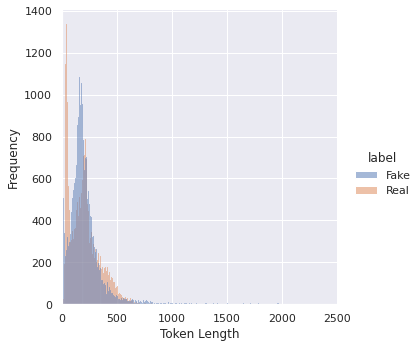

In [203]:
from matplotlib import pyplot as plt
import seaborn as sns

from matplotlib import rcParams

# figure size in inches
#rcParams['figure.figsize'] = 11.7,8.27
#plt.figure(figsize=(12,10))
#multiple="stack",, kind="kde", fill=True
sns.set_theme();
sns.set(rc={'figure.figsize':(13,10)})
#fig, ax = plt.subplots()
#sns.set_size_inches(11.7, 8.27)
sns.displot(df, x="token_length",hue="label")
plt.xlim([0, 2500]);
plt.xlabel('Token Length');
plt.ylabel('Frequency');
plt.show()

#### Visualizing Networks of Co-occurring Word
The  bigrams can be  visualized looking at  the top occurring bigrams as networks using the Python package NetworkX.

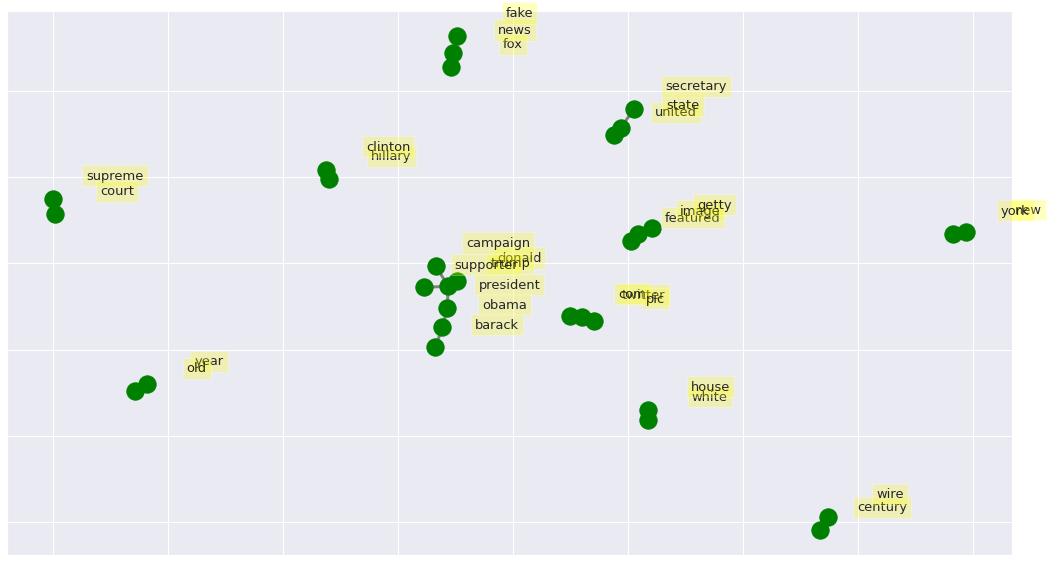

In [204]:
import networkx as nx

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))


fig, ax = plt.subplots(figsize=(18, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='green',
                 with_labels = False,
                 ax=ax)


# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='yellow', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

#### Sentiment Analysis with Vader
- For top 2000 highest frequency words in Fake/Real determine polarity of each with vader from Textblob package. The polarity  will then be used to classify news as either negative,positive or neutral. 

In [207]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize

#df.info()
df.drop_duplicates(subset = "text", keep = "first", inplace = True)


def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df['Polarity'] = df['text'].progress_apply(get_polarity)

In [212]:
df['sentiment_vader']=''
df.loc[df.Polarity>0,'sentiment_vader']='POSITIVE'
df.loc[df.Polarity==0,'sentiment_vader']='NEUTRAL'
df.loc[df.Polarity<0,'sentiment_vader']='NEGATIVE'
#df.head()

In [213]:
df["label"].replace({0:"Fake",  1:"Real"},inplace=True)
temp=df.groupby(['label','sentiment_vader']).apply(lambda x:x['sentiment_vader'].count()).reset_index(name='Counts')
temp.style.background_gradient(cmap='Greens')

,label,sentiment_vader,Counts
0,Fake,NEGATIVE,4185
1,Fake,NEUTRAL,322
2,Fake,POSITIVE,12947
3,Real,NEGATIVE,4654
4,Real,NEUTRAL,551
5,Real,POSITIVE,15987


In [96]:
#temp=df.groupby(['label','sentiment_vader']).agg(['count']).reset_index()[['label','sentiment_vader','title']]
#temp.rename(columns={'title': 'Counts'}, inplace=True)
#temp
#

In [214]:
fig = px.bar(temp, x="label", y="Counts", facet_col="sentiment_vader",
             color=["crimson","crimson","crimson","green","green","green"],text='Counts')
#Forcing an axis to be categorical
fig.update_xaxes(type='category')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(showlegend=False)
fig.update_layout( template="plotly_white")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file12.html")

In [215]:
fig = px.bar(temp, x="label", y="Counts",color="sentiment_vader", barmode="group",text='Counts')
#Forcing an axis to be categorical
fig.update_xaxes(type='category')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Sentiment Distribution over Real and Fake News')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(barmode='group', xaxis_tickangle=0)
fig.update_layout(barmode='group', xaxis={'categoryorder':'category ascending'})
fig.update_layout(
    legend=dict(
        x=1,
        y=1,
        traceorder="reversed",
        #title_font_family="Times New Roman",
        font=dict(
            family="Courier",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)

fig.update_layout( template="simple_white")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file13.html")

#### Has the News Grown More Negative Between 2015 to 2018?

Yes. The proportion of negative sentiments in the news has increased  between 2015 to 2017.


In [218]:
df.head()

,title,text,subject,date,label,Polarity,sentiment_vader,year,month,day
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,Real,0.037083,POSITIVE,2017.0,12.0,31.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,Real,0.055880,POSITIVE,2017.0,12.0,29.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,Real,0.115930,POSITIVE,2017.0,12.0,31.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,Real,0.035968,POSITIVE,2017.0,12.0,30.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,Real,0.030093,POSITIVE,2017.0,12.0,29.0


In [222]:

df["date"] = pd.to_datetime(df["date"], errors='coerce')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['year'] = df['year'].fillna(0)
df['year'] = df['year'].astype(int)
temp=df.groupby(['year','sentiment_vader']).agg({'title':'count'}).query('year>0')
temp = temp.groupby(level=0).apply(lambda x:1 * x / float(x.sum())).reset_index()
temp.rename(columns={'title': 'Ratio'}, inplace=True)
temp.style.background_gradient(cmap='Blues')

,year,sentiment_vader,Ratio
0,2015,NEGATIVE,0.250470
1,2015,NEUTRAL,0.028804
2,2015,POSITIVE,0.720726
3,2016,NEGATIVE,0.199669
4,2016,NEUTRAL,0.021059
5,2016,POSITIVE,0.779271
6,2017,NEGATIVE,0.244642
7,2017,NEUTRAL,0.022905
8,2017,POSITIVE,0.732453
9,2018,NEGATIVE,0.314286


In [223]:
fig = px.bar(temp, x="year", y="Ratio",color="sentiment_vader", barmode="group")
#Forcing an axis to be categorical
fig.update_xaxes(type='category')
#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_xaxes(type='category')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Sentiment Distribution over Real and Fake News')
#fig.update_traces( texttemplate='{}',textposition='outside')
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(barmode='group', xaxis={'categoryorder':'category ascending'})
fig.update_layout(yaxis=dict(tickformat=".0%"))
fig.update_yaxes(title="Percent",title_font_family="Arial")
fig.update_layout( template="ggplot2")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file14.html")

In [226]:
temp=df.groupby(['day','sentiment_vader']).agg({'title':'count'})
temp = temp.groupby(level=0).apply(lambda x:1 * x / float(x.sum())).reset_index()
temp.rename(columns={'title': 'Ratio'}, inplace=True)
#fig = px.line(temp, x="day", y="Ratio",color="sentiment_vader",line_group="sentiment_vader")
fig = go.Figure()
fig.add_trace(go.Scatter(x=temp[temp.sentiment_vader=="POSITIVE"]["day"], 
                         y=temp[temp.sentiment_vader=="POSITIVE"]["Ratio"],
                    mode='lines+markers',
                    name='POSITIVE'))
fig.add_trace(go.Scatter(x=temp[temp.sentiment_vader=="NEGATIVE"]["day"], 
                         y=temp[temp.sentiment_vader=="NEGATIVE"]["Ratio"],
                    mode='lines+markers',
                    name='NEGATIVE'))
fig.add_trace(go.Scatter(x=temp[temp.sentiment_vader=="NEUTRAL"]["day"], 
                         y=temp[temp.sentiment_vader=="NEUTRAL"]["Ratio"],
                    mode='lines+markers', name='NEUTRAL'))
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Sentiment Distribution over Real and Fake News Every Day of The Month')
fig.update_layout( template="plotly_dark")
fig.update_layout(xaxis_tickangle=-45)
#["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]
fig.update_layout(yaxis=dict(tickformat=".0%"))
fig.update_yaxes(title="Percent",title_font_family="Arial")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/htmlfies/file15.html")

#### Classification of News as Real or Fake using Titles as Features

In [239]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y=  le.fit_transform(df.label)

X_train, X_test, y_train, y_test = train_test_split(df.title, y, test_size = 0.2,random_state=2)

#vectorizer = CountVectorizer().fit(X_train)
vectorizer = TfidfVectorizer(use_idf=True).fit(X_train)
train_x = vectorizer.transform(X_train)
test_x = vectorizer.transform(X_test)


model = LogisticRegression(C=2.5)
model.fit(train_x, y_train)
y_pred = model.predict(test_x)
accuracy_value = roc_auc_score(y_test, y_pred)
print("accuracy score {}".format(accuracy_value))

accuracy score 0.9568209165268219
CPU times: user 1.77 s, sys: 1.14 s, total: 2.91 s
Wall time: 2.31 s


The title alone can predict fake or reals by nearly 96% accuracy.

#### Classification of News as Real or Fake with Text as Features

In [240]:
%%time

X_train, X_test, y_train, y_test = train_test_split(df.text, y, test_size = 0.2,random_state=2)

vectorizer = CountVectorizer().fit(X_train)
#vectorizer = TfidfVectorizer(use_idf=True).fit(X_train)
train_x = vectorizer.transform(X_train)
test_x = vectorizer.transform(X_test)
model = xgb.XGBClassifier(
              n_jobs = -1,
              max_depth = 6,
              #learning_rate=  0.1,
              min_child_weight= 2, 
              #min_samples_split= 0.9,
              n_estimators= 100,
              eta = 0.1, 
              verbose = 1, 
              gamma=0.05,
              #nrounds = 100
              objective = "binary:logistic", 
              eval_metric = "auc",       #"aucpr",    # "aucpr",  #aucpr, auc
              subsample = 0.7,
              colsample_bytree =0.8,
              max_delta_step=1,
              verbosity=1,
              tree_method='approx')

model.fit(train_x, y_train)
y_pred = model.predict(test_x)
accuracy_value = roc_auc_score(y_test, y_pred)
print("accuracy score {}".format(accuracy_value))

accuracy score 0.9970340274765952
CPU times: user 3min 45s, sys: 359 ms, total: 3min 45s
Wall time: 2min 8s


#### Classification of News as Real or Fake with Title and Text Combined as Features

In [244]:
%%time
X_train, X_test, y_train, y_test = train_test_split(df.title_text, y, test_size = 0.2,random_state=2)

vectorizer = CountVectorizer().fit(X_train)
#vectorizer = TfidfVectorizer(use_idf=True).fit(X_train)
train_x = vectorizer.transform(X_train)
test_x = vectorizer.transform(X_test)

model = xgb.XGBClassifier(
              n_jobs = -1,
              max_depth = 6,
              #learning_rate=  0.1,
              min_child_weight= 2, 
              #min_samples_split= 0.9,
              n_estimators= 100,
              eta = 0.1, 
              verbose = 1, 
              gamma=0.05,
              #nrounds = 100
              objective = "binary:logistic", 
              eval_metric = "auc",       #"aucpr",    # "aucpr",  #aucpr, auc
              subsample = 0.7,
              colsample_bytree =0.8,
              max_delta_step=1,
              verbosity=1,

              tree_method='approx')
#model = LogisticRegression(C=2.5)
model.fit(train_x, y_train)
y_pred = model.predict(test_x)
accuracy_value = roc_auc_score(y_test, y_pred)
print("accuracy score {}".format(accuracy_value))

accuracy score 0.9975657161197259
CPU times: user 3min 51s, sys: 693 ms, total: 3min 52s
Wall time: 2min 12s


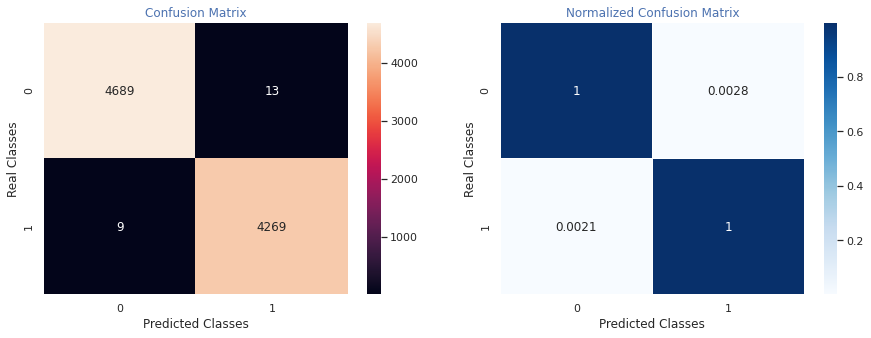

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4702
           1       1.00      1.00      1.00      4278

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [245]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
p=0.5

def PlotConfusionMatrix(y_test,pred,y_test_normal,y_test_pneumonia,label):

    cfn_matrix = confusion_matrix(y_test,pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_normal,1.0/y_test_normal],[1.0/y_test_pneumonia,1.0/y_test_pneumonia]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    #colsum=cfn_matrix.sum(axis=0)
    #norm_cfn_matrix = cfn_matrix / np.vstack((colsum, colsum)).T

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    #sns.heatmap(cfn_matrix,cmap='magma',linewidths=0.5,annot=True,ax=ax,annot=True)
    sns.heatmap(cfn_matrix, annot = True,fmt='g',cmap='rocket')
    #tick_marks = np.arange(len(y_test))
    #plt.xticks(tick_marks, np.unique(y_test), rotation=45)
    plt.title('Confusion Matrix',color='b')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/NLP/cm_' +label +  '.png')
        
    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap=plt.cm.Blues,linewidths=0.5,ax=ax,annot=True)

    plt.title('Normalized Confusion Matrix',color='b')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/NLP/cm_norm' +label +  '.png')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))
    

y_test_real,y_test_fake = np.bincount(y_test)
y_pred= np.where(y_pred<p,0,1 )


PlotConfusionMatrix(y_test,y_pred,y_test_real,y_test_fake,label= 'classification Report')

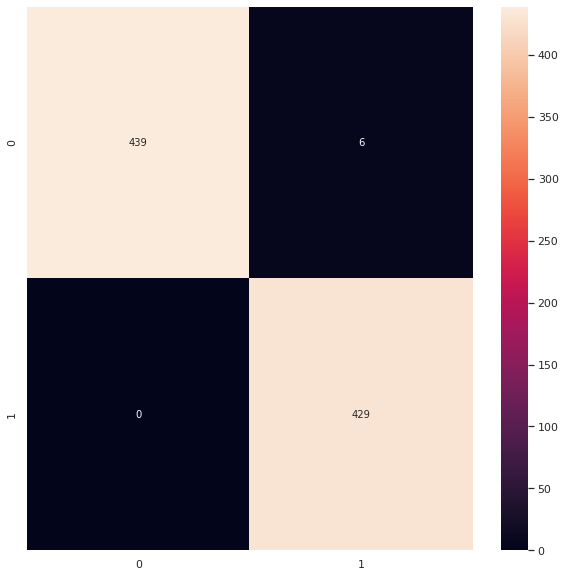

In [151]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='rocket')
plt.title('Normalized Confusion Matrix',color='b')
plt.ylabel('Real Classes')
plt.xlabel('Predicted Classes')
plt.show()